# CV Shift Weight Generator Notebook

### Notes

Notebook attempts to approximate:

$\frac{f_{test}(x_i)}{f_{train}(x_i)}$ as $\frac{Pr(x_i)}{1-Pr(x_i)}$, where $Pr(x_i)$ is the probability that observation i is in the test set.

### Imports

In [1]:
import pandas as pd
import numpy as np
import copy
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.cross_validation import cross_val_score
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

print("------Imports complete------")

/home/matia_alexander/miniconda3/envs/deeplearning/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


------Imports complete------


### Load Data

In [52]:
data_path = "/home/matia_alexander/data/home-credit-default-risk/"
application_train = pd.read_csv(data_path + "application_train.csv")
bureau_balance = pd.read_csv(data_path + "bureau_balance.csv")
bureau = pd.read_csv(data_path + "bureau.csv")
credit_card_balance = pd.read_csv(data_path + "credit_card_balance.csv")
installments_payments = pd.read_csv(data_path + "installments_payments.csv")
POS_CASH_balance = pd.read_csv(data_path + "POS_CASH_balance.csv")
previous_application = pd.read_csv(data_path + "previous_application.csv")
sample_submission = pd.read_csv(data_path + "sample_submission.csv")
application_test = pd.read_csv(data_path + 'application_test.csv')  
#Add flags for origination
application_train['Data_Set'] = 0
application_train.drop(columns = "TARGET", inplace = True)
application_test['Data_Set'] = 1

### Data Manipulation

In [3]:
# Stack test/train datasets
application_all = pd.concat([application_train, application_test])

#One-hot encode non-numeric fields for use in xgboost
non_numeric_cols = []
for i in application_all.columns:
    if application_all[i].dtype.name == "object":
        non_numeric_cols.append(i)

#Build dataset of only non-numerics
application_all_non_numeric = application_all.loc[:,non_numeric_cols]
#Remove non-encoded variables from original dataset
application_all.drop(columns = non_numeric_cols, inplace = True)
#Convert non-numerics into dummies/ one-hot encode
application_all_non_numeric_dummies = pd.get_dummies(application_all_non_numeric)
#Join encoded dataset back with original
application_all = pd.concat([application_all, application_all_non_numeric_dummies], axis = 1)

X = application_all.drop(columns = ["SK_ID_CURR", "Data_Set"])
y = application_all["Data_Set"]

In [4]:
print(y.shape)
print(X.shape)

(356255,)
(356255, 244)


Take several bootstrap samples of data, train model, and then predict probabilities on train set.  Hopefully this reduces overfit stemming from cases where model has seen a specific case, and thus knows exactly what it will.  Exact precision is obviously undesireable in this case given the potential for unbounded weights.

In [8]:
all_rows = pd.Series(range(0, X.shape[0]))


In [9]:
Test_Set = application_all.loc[application_all.Data_Set == 0,:]

In [11]:
Pred_List = []

for i in range(0,15):
    print("Iteration: " + str(i))
    X_sample_rows = all_rows.sample(frac = .3)
    X_sample = X.iloc[X_sample_rows]
    y_sample = y.iloc[X_sample_rows]
    print(X_sample.shape)
    print(y_sample.shape)

    model = XGBClassifier(learning_rate=.02,
                        n_estimators=300,
                        bootstrap = True,
                        min_samples_leaf = 8,
                        min_samples_split = 10,
                        min_child_weight=1,
                        colsample_byree = .6,
                        max_features="auto",
                        max_depth = 20,
                        gamma = 2,
                        objective = 'binary:logistic',
                        silent = False,
                        nthread=4)
    model.fit(X_sample,y_sample)
    if i == 0:
        Pred_Frame = pd.DataFrame( model.predict_proba(Test_Set.drop(columns = ["SK_ID_CURR", "Data_Set"]))[:,0],
            columns = ["pred_"+ str(i) ])
    else:
        tmp_frame = pd.DataFrame( model.predict_proba(Test_Set.drop(columns = ["SK_ID_CURR", "Data_Set"]))[:,0],
            columns = ["pred_"+ str(i) ])
        
        Pred_Frame = pd.concat([Pred_Frame, tmp_frame], axis = 1)

Pred_Frame.to_csv("/home/matia_alexander/data/home-credit-default-risk/modified/Predictions_Bootstrap.csv")

Iteration: 0
(106876, 244)
(106876,)
Iteration: 1
(106876, 244)
(106876,)
Iteration: 2
(106876, 244)
(106876,)
Iteration: 3
(106876, 244)
(106876,)
Iteration: 4
(106876, 244)
(106876,)
Iteration: 5
(106876, 244)
(106876,)
Iteration: 6
(106876, 244)
(106876,)
Iteration: 7
(106876, 244)
(106876,)
Iteration: 8
(106876, 244)
(106876,)
Iteration: 9
(106876, 244)
(106876,)
Iteration: 10
(106876, 244)
(106876,)
Iteration: 12
(106876, 244)
(106876,)
Iteration: 13
(106876, 244)
(106876,)
Iteration: 14
(106876, 244)
(106876,)


In [42]:
Pred_Frame = pd.read_csv("/home/matia_alexander/data/home-credit-default-risk/modified/Predictions_Bootstrap.csv")
Pred_Frame.drop(columns = ["Unnamed: 0"], inplace = True)
Pred_Frame = 1 - Pred_Frame
Average_Test_Prob = Pred_Frame.mean(axis = 1 )
Weight = Average_Test_Prob / (1 - Average_Test_Prob)

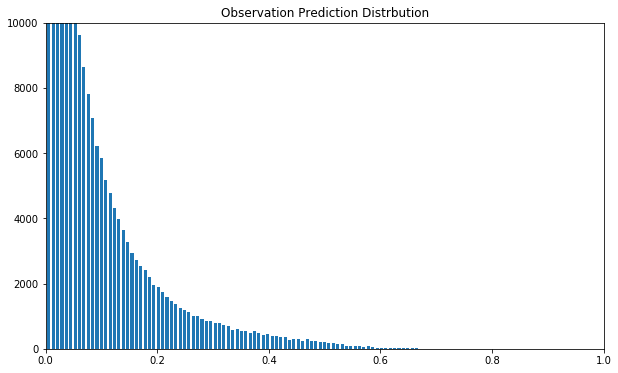

In [43]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]
ht, bins = np.histogram(a = Average_Test_Prob,
            bins = 100)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, ht, width = width)
plt.axis([0,1,0,10000])
plt.title("Observation Prediction Distrbution")
plt.show()

0.092084681313143

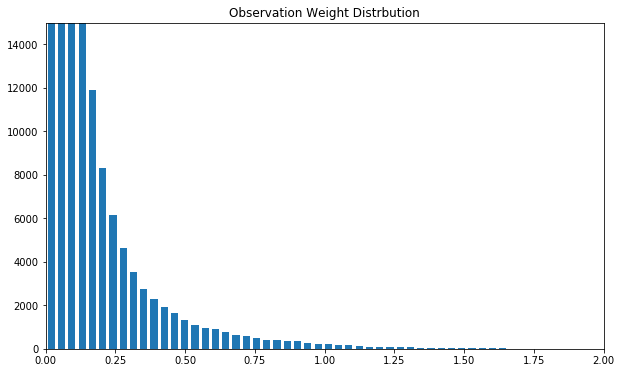

In [84]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]
ht, bins = np.histogram(a = Weight,
            bins = 100)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, ht, width = width)
plt.axis([0,2,0,15000])
plt.title("Observation Weight Distrbution")
plt.show()

In [82]:
#Check to ensure that every training record has been assigned a weight:
len_1 = application_train.shape[0]
len_2 = len(Weight)
assert(len_1 == len_2)

In [77]:
Train_Weights = pd.DataFrame(application_train['SK_ID_CURR'].values, columns = ["SK_ID_CURR"])
Train_Weights["Weights"] = Weight
Train_Weights.to_csv("/home/matia_alexander/data/home-credit-default-risk/modified/Train_Weights_V1.csv")
Train_Weights.head()

,SK_ID_CURR,Weights
0,100002,0.083370
1,100003,0.009126
2,100004,0.008843
3,100006,0.172303
4,100007,0.018923
